# Data Preparation

## Load data from sqlite3 in json

In [37]:
from utils.db.get_data_db import get_data_json
from utils.information_retrieval import get_data_per_rq, get_means_from_traces
from utils.models import get_times_inference, get_answers_rq1_inference, get_answers_rq2_3_inference, get_confidence_inference
from utils.visualization import scatter_plot_of_num_len_boxes, pair_plot_response_interaction
#conda install -c conda-forge adjusttext

import numpy as np

import warnings
warnings.filterwarnings('ignore')

db_file_path = 'data/study_01.db'
data = get_data_json(db_file_path)
#data

## Data cleaning

Keep only full registrations.

In [2]:
data_processed = {}
for p in data:
    if data[p]['status'] == "end_thanks":
        data_processed[p] = data[p]

## Get observed Response Times, Accuracy, and Confidence per Research Question (RQ) and group (IG and SG)

<!-- There are 3 research questions in the study. -->

RQ1: Does interaction help users to identify the existence or not of (strong) relations among probabilistic models’ parameters 

RQ2: Does interaction help users to identify the type of relation of model’s parameters and/or predictions 

RQ3: Does interaction help users to infer structural information about the model

more accurately, faster and with more confidence?

IG: Interactive Group

SG: Static Group

<!-- The study consisted of 3 problems. Each problem was modelled by a different probabilistic model. There were 3 sets of questions in each problem with every set corresponding to one of the research questions. -->

<!-- The task ids per problem and RQ are following:

**Problem 1: Temperature in Scotland**

RQ1: t1

RQ2: t2, t3, t4

RQ3: t5

**Problem 2: Random real-number generator**

RQ1: t6

RQ2: t7, t8, t9

RQ3: t10, t11

**Problem 3: Lorry drivers reaction times**

RQ1: t12, t13

RQ2: t14, t15, t16, t17

RQ3: t18, t19 -->

In [3]:
# task ids per RQ
t_ids = {}
t_ids['rq1'] = ['t1','t6','t12','t13']
t_ids['rq2'] = ['t2','t3','t4','t7','t8','t9','t14','t15','t16','t17']
t_ids['rq3'] = ['t5','t10','t11','t18','t19']

times_i, times_s, corr_answers_i, corr_answers_s, conf_i, conf_s = get_data_per_rq(data_processed, t_ids, db_file_path)

## Get observed Lengths and Numbers of Interactive Selection Boxes per Task and Variable

In [4]:
import json
def get_num_of_boxes(data, p_tasks, p_vars, t_vars):
    """
        p_tasks:     correspondence of tasks to problems {"p1":[t1,t2..],"p2":[]}
        p_vars:      correspondence of variables to problems {"p1":[a,b..],"p2":[a,b..]}
        
        Returns:     participants number of selection boxes per task and variable e.g. t1_p1_a, t1_p1_b, ...
    """
    num_boxes = {}
    for p_id,p in data.items():
        if p['mode'] == "i": 
            for t_id, t_response in p['t_answers'].items():
                num_boxes_dict = {}
                if t_id in p_tasks['p1']:
                    prob = 'p1'
                elif t_id in p_tasks['p2']:
                    prob = 'p2'
                else:
                    prob = 'p3'
                ## get νθμ_boxes of participant p_id for task t_id per variable
                for i, sel in t_response['selections'].items():
                    if sel["var_name"] not in p_vars[prob]:
                        continue
                    if sel["var_name"] not in num_boxes_dict:
                        num_boxes_dict[sel["var_name"]] = 1
                    else:
                        num_boxes_dict[sel["var_name"]] = num_boxes_dict[sel["var_name"]] + 1
                ## add 0 for variables that participant didn't interact with
                for var in t_vars[t_id]:
                    if var not in num_boxes_dict:
                        num_boxes_dict[var] = 0
                ## add num_boxes of participant p_id for task t_id per variable
                for var, nums in num_boxes_dict.items():
                    t_id_var = t_id+"_"+prob+"_"+var
                    if t_id_var not in num_boxes:
                        num_boxes[t_id_var] = []
                    num_boxes[t_id_var].append(nums)
    return num_boxes

def get_len_of_boxes(data, p_tasks, p_vars, p_inference):
    """
        p_tasks:     correspondence of tasks to problems {"p1":[t1,t2..],"p2":[]}
        p_vars:      correspondence of variables to problems {"p1":[a,b..],"p2":[a,b..]}
        p_inference: correspondence of inference to problems {"p1":{},"p2":{}}
        
        Returns:     participants median length of selection box per task and variable e.g. t1_p1_a, t1_p1_b, ...
    """
    ## estimate normalization factor of each variable in each problem
    p_norm_factors = {}   
    for p, inference in p_inference.items():
        p_array_names = json.loads(p_inference[p]['header.json'])["inference_data"]["prior"]["array_names"]
        if p not in p_norm_factors:
            p_norm_factors[p] = {}
        for var in p_vars[p]:
            prior_samples = np.squeeze(p_inference[p][p_array_names[var]])
            if p == 'p3' and len(prior_samples.shape)>1:
                prior_samples = prior_samples[:,2]
            p_norm_factors[p][var] =  prior_samples.max()-prior_samples.min()
#             hdi = az.hdi(prior_samples, hdi_prob=.94)
#             p_norm_factors[p][var] =  hdi[1] - hdi[0]
    ##
    len_boxes = {}
    for p_id,p in data.items():
        if p['mode'] == "i":        
            for t_id, t_response in p['t_answers'].items():
                len_boxes_dict = {}
                if t_id in p_tasks['p1']:
                    prob = 'p1'
                elif t_id in p_tasks['p2']:
                    prob = 'p2'
                else:
                    prob = 'p3'
                ## get len_boxes of participant p_id for task t_id per variable
                for i, sel in t_response['selections'].items():
                    if sel["var_name"] not in p_vars[prob]:
                        continue
                    if sel["var_name"] not in len_boxes_dict:
                        len_boxes_dict[sel["var_name"]] = []
                    len_boxes_dict[sel["var_name"]].append((sel['xmax']-sel['xmin'])/p_norm_factors[prob][sel["var_name"]] )
                ## aggregate len_boxes of participant p_id for task t_id per variable
                for var, lengths in len_boxes_dict.items():
                    t_id_var = t_id+"_"+prob+"_"+var
                    if t_id_var not in len_boxes:
                        len_boxes[t_id_var] = []
                    len_boxes[t_id_var].append(np.median(lengths))
#                     if len_boxes[t_id_var][-1]>1:
#                         print(p_id,t_id,var,lengths)
    return len_boxes

In [5]:
p_tasks = {"p1":['t1','t2',"t3","t4",'t5'],"p2":['t6','t7',"t8","t9",'t10','t11'],"p3":['t12','t13',"t14","t15",'t16','t17','t18','t19']}
p_vars = {"p1":['a','b','c'],"p2":['a','b','c'],"p3":['a','b','c','d']}
p_inference = {"p1":np.load('data/min_temperature.npz') ,"p2":np.load('data/transformation.npz'),"p3":np.load('data/reaction_times_hierarchical.npz')}
t_vars = {'t1':['a','b','c'],'t2':['a'],'t3':['b'],'t4':['c'],'t5':['a','b','c'],'t6':['a','b','c'],'t7':['a'],'t8':['b'],'t9':['c'],'t10':['a','b','c'],'t11':['a','b','c'],'t12':['a','b','c','d'],'t13':['a','b','c','d'],'t14':['a'],'t15':['b'],'t16':['c'],'t17':['d'],'t18':['a','c'],'t19':['a','b']}

num_of_boxes = get_num_of_boxes(data_processed, p_tasks, p_vars, t_vars) 
len_of_boxes = get_len_of_boxes(data_processed, p_tasks, p_vars, p_inference)

# Bayesian Analysis of Collected Data

## Inference for RQ1

### Response Times

In [6]:
# interactive and static response times
tim_i = [j for _,value in times_i['rq1'].items() for j in value]
tim_s = [j for _,value in  times_s['rq1'].items() for j in value]
#indices
t_indices_i = [t_ids['rq1'].index(t) 
               for t,value in times_i['rq1'].items() 
               for j in value]
t_indices_s = [t_ids['rq1'].index(t) 
               for t,value in times_s['rq1'].items() 
               for j in value]
trace_rt_rq1, pp_rt_rq1 = get_times_inference(tim_i, 
                                              tim_s, 
                                              t_indices_i, 
                                              t_indices_s, 
                                              t_ids['rq1'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groups_std, groups_mean, groupi_std, groupi_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 44 seconds.


### Accuracy
We model the probability of making a mistake in identifying the existence or not of a relation.

In [7]:
# number of trials (available options) per task in rq1
n_sizes_per_task = {'t1':3,'t6':3,'t12':4,'t13':3}
n_i = [n_sizes_per_task[t] 
       for t,value in corr_answers_i['rq1'].items() 
       for j in value]
n_s = [n_sizes_per_task[t] 
       for t,value in corr_answers_s['rq1'].items() 
       for j in value]
# interactive and static answers
ans_i = [j for _,value in corr_answers_i['rq1'].items() 
         for j in value]
ans_s = [j for _,value in corr_answers_s['rq1'].items() 
         for j in value]
#indices 
t_indices_i = [t_ids['rq1'].index(t) 
               for t,value in corr_answers_i['rq1'].items() 
               for j in value]
t_indices_s = [t_ids['rq1'].index(t) 
               for t,value in corr_answers_s['rq1'].items() 
               for j in value]
trace_acc_rq1, pp_acc_rq1 = get_answers_rq1_inference(ans_i, 
                                                      ans_s, n_i, n_s, 
                                                      t_indices_i, 
                                                      t_indices_s, 
                                                      t_ids['rq1'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas, thetai]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.


### Confidence

In [8]:
# interactive and static response times
c_i = [j for _,value in conf_i['rq1'].items() 
       for j in value]
c_s = [j for _,value in conf_s['rq1'].items() 
       for j in value]
#indices
t_indices_i = [t_ids['rq1'].index(t) 
               for t,value in conf_i['rq1'].items() 
               for j in value]
t_indices_s = [t_ids['rq1'].index(t) 
               for t,value in conf_s['rq1'].items() 
               for j in value]

trace_conf_rq1, pp_conf_rq1 = get_confidence_inference(c_i, 
                                                       c_s, 
                                                       t_indices_i, 
                                                       t_indices_s, 
                                                       t_ids['rq1'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groups_std, groups_mean, groupi_std, groupi_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.


## Inference for RQ2

### Response Times

In [9]:
# interactive and static response times
tim_i = [j for _,value in times_i['rq2'].items() 
         for j in value]
tim_s = [j for _,value in  times_s['rq2'].items() 
         for j in value]
#indices
t_indices_i = [t_ids['rq2'].index(t) 
               for t,value in times_i['rq2'].items() 
               for j in value]
t_indices_s = [t_ids['rq2'].index(t) 
               for t,value in times_s['rq2'].items() 
               for j in value]
trace_rt_rq2, pp_rt_rq2 = get_times_inference(tim_i, 
                                              tim_s, 
                                              t_indices_i, 
                                              t_indices_s, 
                                              t_ids['rq2'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groups_std, groups_mean, groupi_std, groupi_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 45 seconds.


### Accuracy

In [10]:
# interactive and static answers
ans_i = [j for _,value in corr_answers_i['rq2'].items() 
         for j in value]
ans_s = [j for _,value in corr_answers_s['rq2'].items() 
         for j in value]
#indices 
t_indices_i = [t_ids['rq2'].index(t) 
               for t,value in corr_answers_i['rq2'].items() 
               for j in value]
t_indices_s = [t_ids['rq2'].index(t) 
               for t,value in corr_answers_s['rq2'].items() 
               for j in value]

trace_acc_rq2, pp_acc_rq2 = get_answers_rq2_3_inference(ans_i, 
                                                        ans_s, 
                                                        t_indices_i, 
                                                        t_indices_s, 
                                                        t_ids['rq2'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas, thetai]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.


### Confidence

In [11]:
# interactive and static response times
c_i = [j for _,value in conf_i['rq2'].items() 
       for j in value]
c_s = [j for _,value in conf_s['rq2'].items() 
       for j in value]
#indexes
t_indices_i = [t_ids['rq2'].index(t) 
               for t,value in conf_i['rq2'].items() 
               for j in value]
t_indices_s = [t_ids['rq2'].index(t) 
               for t,value in conf_s['rq2'].items() 
               for j in value]
trace_conf_rq2, pp_conf_rq2 = get_confidence_inference(c_i, 
                                                       c_s, 
                                                       t_indices_i, 
                                                       t_indices_s, 
                                                       t_ids['rq2'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groups_std, groups_mean, groupi_std, groupi_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 47 seconds.


## Inference for RQ3

### Response Times

In [12]:
# interactive and static response times
tim_i = [j for _,value in times_i['rq3'].items() 
         for j in value]
tim_s = [j for _,value in  times_s['rq3'].items() 
         for j in value]
#indices
t_indices_i = [t_ids['rq3'].index(t) 
               for t,value in times_i['rq3'].items() 
               for j in value]
t_indices_s = [t_ids['rq3'].index(t) 
               for t,value in times_s['rq3'].items() 
               for j in value]
trace_rt_rq3, pp_rt_rq3 = get_times_inference(tim_i, 
                                              tim_s, 
                                              t_indices_i, 
                                              t_indices_s, 
                                              t_ids['rq3'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groups_std, groups_mean, groupi_std, groupi_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 45 seconds.


### Accuracy

In [13]:
# interactive and static answers
ans_i = [j for _,value in corr_answers_i['rq3'].items() 
         for j in value]
ans_s = [j for _,value in corr_answers_s['rq3'].items() 
         for j in value]
#indices 
t_indices_i = [t_ids['rq3'].index(t) 
               for t,value in corr_answers_i['rq3'].items() 
               for j in value]
t_indices_s = [t_ids['rq3'].index(t) 
               for t,value in corr_answers_s['rq3'].items() 
               for j in value]

trace_acc_rq3, pp_acc_rq3 = get_answers_rq2_3_inference(ans_i, 
                                                        ans_s, 
                                                        t_indices_i, 
                                                        t_indices_s, 
                                                        t_ids['rq3'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas, thetai]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.


### Confidence

In [14]:
# interactive and static response times
c_i = [j for _,value in conf_i['rq3'].items() 
       for j in value]
c_s = [j for _,value in conf_s['rq3'].items() 
       for j in value]
#indexes
t_indices_i = [t_ids['rq3'].index(t) 
               for t,value in conf_i['rq3'].items() 
               for j in value]
t_indices_s = [t_ids['rq3'].index(t) 
               for t,value in conf_s['rq3'].items() 
               for j in value]
trace_conf_rq3, pp_conf_rq3 = get_confidence_inference(c_i, 
                                                       c_s, 
                                                       t_indices_i, 
                                                       t_indices_s, 
                                                       t_ids['rq3'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groups_std, groups_mean, groupi_std, groupi_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 44 seconds.


## Inference for Lengths of Interactive Selection Boxes

In [15]:
import pymc3 as pm
def get_len_boxes_inference_h(len_boxes, task_var_indices, task_var_ids, var_names, t_var_indices):
    """
        len_boxes:        List of median length of selectin box for each variable in each task
        task_var_ids:     List of task variables ids e.g. t1_p1_a, t1_p1_b ....
        var_names:        List of problems variables names e.g. p1_a, p1_b, ...
        task_var_indices: List of indices to problems variables names for each task variable
        t_var_indices:    List of indices to task variables for each observation in len_box
    """    
    coords = {"var":var_names,"task_var": task_var_ids}
    with pm.Model(coords=coords) as model:
        #hyper priors for vars
        mu_mu = pm.Beta("mu_mu", alpha = 1, beta = 1, dims='var')
        mu_kappa= pm.Gamma("mu_kappa", alpha = 100, beta = 1, dims='var')
        kappa_alpha = pm.Gamma("kappa_alpha", alpha = 100, beta = 1, dims='var')        
        kappa_beta = pm.Gamma("kappa_beta", alpha = 100, beta = 1, dims='var')

        #priors
        mu = pm.Beta("mu", alpha = mu_mu[task_var_indices]*mu_kappa[task_var_indices], beta = (1-mu_mu[task_var_indices])*mu_kappa[task_var_indices], dims='task_var')
        kappa = pm.Gamma("kappa", alpha = kappa_alpha[task_var_indices], beta = kappa_beta[task_var_indices], dims='task_var')

        #likelihood                
        len_box = pm.Beta("len_box", alpha = mu[t_var_indices]*kappa[t_var_indices], beta = kappa[t_var_indices]*(1-mu[t_var_indices]), observed = len_boxes)#length of selection box

        #inference
        trace = pm.sample(2000,cores=1)
        posterior_predictive = pm.sample_posterior_predictive(trace, samples=2000)
    return trace, posterior_predictive

def get_num_boxes_inference_h(num_boxes, task_var_indices, task_var_ids, var_names, t_var_indices):
    """
        num_boxes:        List of number of selectin boxes for each variable in each task
        task_var_ids:     List of task variables ids e.g. t1_p1_a, t1_p1_b ....
        var_names:        List of problems variables names e.g. p1_a, p1_b, ...
        task_var_indices: List of indices to problems variables names for each task variable
        t_var_indices:    List of indices to task variables for each observation in len_box
    """    
    coords = {"var":var_names,"task_var": task_var_ids}
    with pm.Model(coords=coords) as model:
        #hyper priors for vars
        mu_alpha = pm.Gamma("mu_alpha", alpha = 2, beta = 10, dims='var')
        mu_beta = pm.Gamma("mu_beta", alpha = 1, beta = 5, dims='var')    

        #priors
        mu = pm.Gamma("mu", alpha = mu_alpha[task_var_indices], beta = mu_beta[task_var_indices], dims='task_var')

        #likelihood                
        num_box = pm.Poisson("num_box", mu = mu[t_var_indices], observed = num_boxes)#number of selection boxes

        #inference
        trace = pm.sample(2000)
        posterior_predictive = pm.sample_posterior_predictive(trace, samples=2000)
    return trace, posterior_predictive

def get_len_boxes_inference_nh(len_boxes, task_var_ids, t_var_indices):
    """
        len_boxes:        List of median length of selectin box for each variable in each task
        task_var_ids:     List of task variables ids e.g. t1_p1_a, t1_p1_b ....
        var_names:        List of problems variables names e.g. p1_a, p1_b, ...
        task_var_indices: List of indices to problems variables names for each task variable
        t_var_indices:    List of indices to task variables for each observation in len_box
    """    
    coords = {"task_var": task_var_ids}
    with pm.Model(coords=coords) as model:
        #priors
        mu = pm.Beta("mu", alpha = 1, beta = 1, dims='task_var')
        kappa = pm.Gamma("kappa", alpha = 100, beta = 1, dims='task_var')

        #likelihood                
        len_box = pm.Beta("len_box", alpha = mu[t_var_indices]*kappa[t_var_indices], beta = kappa[t_var_indices]*(1-mu[t_var_indices]), observed = len_boxes)#length of selection box

        #inference
        trace = pm.sample(2000,cores=1)
        posterior_predictive = pm.sample_posterior_predictive(trace, samples=2000)
    return trace, posterior_predictive

def get_num_boxes_inference_nh(num_boxes, task_var_ids,  t_var_indices):
    """
        num_boxes:        List of number of selectin boxes for each variable in each task
        task_var_ids:     List of task variables ids e.g. t1_p1_a, t1_p1_b ....
        var_names:        List of problems variables names e.g. p1_a, p1_b, ...
        task_var_indices: List of indices to problems variables names for each task variable
        t_var_indices:    List of indices to task variables for each observation in len_box
    """    
    coords = {"task_var": task_var_ids}
    with pm.Model(coords=coords) as model:
        #priors
        mu = pm.Gamma("mu", alpha = 2, beta = 10, dims='task_var')

        #likelihood                
        num_box = pm.Poisson("num_box", mu = mu[t_var_indices], observed = num_boxes)#number of selection boxes

        #inference
        trace = pm.sample(2000)
        posterior_predictive = pm.sample_posterior_predictive(trace, samples=2000)
    return trace, posterior_predictive

In [16]:
## observed lengths of boxes
len_boxes = [j for _,value in len_of_boxes.items() 
         for j in value]
## dims 
task_var_ids = ["t1_p1_a", "t1_p1_b", "t1_p1_c", "t2_p1_a", "t3_p1_b", "t4_p1_c", "t5_p1_a", "t5_p1_b", "t5_p1_c",
               "t6_p2_a", "t6_p2_b", "t6_p2_c", "t7_p2_a", "t8_p2_b", "t9_p2_c", "t10_p2_a", "t10_p2_b", "t10_p2_c", "t11_p2_a", "t11_p2_b", "t11_p2_c",
               "t12_p3_a", "t12_p3_b", "t12_p3_c", "t12_p3_d", "t13_p3_a", "t13_p3_b", "t13_p3_c", "t13_p3_d", "t14_p3_a", "t15_p3_b", "t16_p3_c", "t17_p3_d", "t18_p3_a", "t18_p3_c", "t19_p3_a", "t19_p3_b"]
var_names = ["p1_a", "p1_b", "p1_c", "p2_a", "p2_b", "p2_c", "p3_a", "p3_b", "p3_c", "p3_d"]
## indices 
task_var_indices = [0,1,2,0,1,2,0,1,2,3,4,5,3,4,5,3,4,5,3,4,5,6,7,8,9,6,7,8,9,6,7,8,9,6,8,6,7]
t_var_indices = [task_var_ids.index(t_var) 
               for t_var,value in len_of_boxes.items() 
               for j in value]
## inference
trace_len_boxes_h, pp_len_boxes_h = get_len_boxes_inference_h(len_boxes, 
                                                    task_var_indices, 
                                                    task_var_ids, 
                                                    var_names,
                                                    t_var_indices)

##
trace_len_boxes_nh, pp_len_boxes_nh = get_len_boxes_inference_nh(len_boxes, task_var_ids, t_var_indices)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [kappa, mu, kappa_beta, kappa_alpha, mu_kappa, mu_mu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 63 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [kappa, mu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 13 seconds.


## Inference for Number of Interactive Selection Boxes

In [17]:
## observed numbers of boxes
num_boxes = [j for _,value in num_of_boxes.items() 
         for j in value]
t_var_indices = [task_var_ids.index(t_var) 
               for t_var,value in num_of_boxes.items() 
               for j in value]
## inference
trace_num_boxes_h, pp_num_boxes_h = get_num_boxes_inference_h(num_boxes, 
                                                    task_var_indices, 
                                                    task_var_ids, 
                                                    var_names,
                                                    t_var_indices)

##
trace_num_boxes_nh, pp_num_boxes_nh = get_num_boxes_inference_nh(num_boxes, task_var_ids,  t_var_indices)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, mu_beta, mu_alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 46 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.


# Visualizations

In [18]:
# means of traces of hierarchical models
traces_dict = {}#{<trace_id>:(<trace>,<posterior_predictive_samples>,<variable>)}
traces_dict['acc_rq1'] = (trace_acc_rq1,pp_acc_rq1,"difference of thetas")
traces_dict['acc_rq2'] = (trace_acc_rq2,pp_acc_rq2,"difference of thetas")
traces_dict['acc_rq3'] = (trace_acc_rq3,pp_acc_rq3,"difference of thetas")
traces_dict['rt_rq1'] = (trace_rt_rq1,pp_rt_rq1,"effect size")
traces_dict['rt_rq2'] = (trace_rt_rq2,pp_rt_rq2,"effect size")
traces_dict['rt_rq3'] = (trace_rt_rq3,pp_rt_rq3,"effect size")
traces_dict['conf_rq1'] = (trace_conf_rq1,pp_conf_rq1,"difference of means")
traces_dict['conf_rq2'] = (trace_conf_rq2,pp_conf_rq2,"difference of means")
traces_dict['conf_rq3'] = (trace_conf_rq3,pp_conf_rq3,"difference of means")
traces_dict['num_boxes'] = (trace_num_boxes_h,pp_num_boxes_h,"mu")
traces_dict['len_boxes'] = (trace_len_boxes_h,pp_len_boxes_h,"mu")
# dict of means of traces
means_h = get_means_from_traces(traces_dict)


# means of traces of non-hierarchical models
traces_dict['num_boxes'] = (trace_num_boxes_nh,pp_num_boxes_nh,"mu")
traces_dict['len_boxes'] = (trace_len_boxes_nh,pp_len_boxes_nh,"mu")
means_nh = get_means_from_traces(traces_dict)

arviz.data.io_pymc3 - WARNING - posterior predictive variable interactive's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive variable static's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive variable interactive's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive variable static's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive variable interactive's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


## Hierarcical Interaction

In [31]:
import pandas as pd
def get_data_interaction_scatter_plot(means_from_traces):
    # prepare data
    rq = ["RQ1"]*3 + ["RQ2"]*3 + ["RQ3"]*3 + ["RQ1"]*3 + ["RQ2"]*3 + ["RQ3"]*6 + ["RQ1"]*8 + ["RQ2"]*4 + ["RQ3"]*4
    pp_data = {}
    pp_data = {'num_boxes':means_from_traces['num_boxes'], 
               'len_boxes':means_from_traces['len_boxes'],
              'Research Question':rq}
    return pd.DataFrame(pp_data)

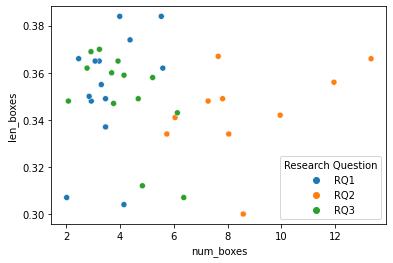

In [32]:
df_num_len_box = get_data_interaction_scatter_plot(means_h)
scatter_plot_of_num_len_boxes(df_num_len_box)

## Non-hierarchical Interaction

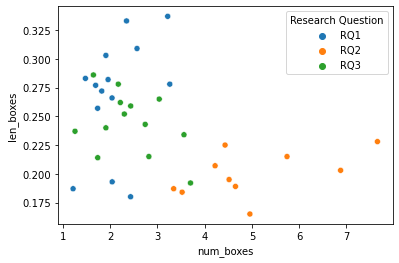

In [33]:
df_num_len_box = get_data_interaction_scatter_plot(means_nh)
scatter_plot_of_num_len_boxes(df_num_len_box)

## Hierarchical Interaction

In [34]:
def get_data_response_interaction_pair_plot(means_from_traces):
    # mean of posteriors
    mean_acc_rq1 = means_from_traces['acc_rq1']
    mean_acc_rq2 = means_from_traces['acc_rq2']
    mean_acc_rq3 = means_from_traces['acc_rq3']
    mean_rt_rq1  = means_from_traces['rt_rq1']
    mean_rt_rq2  = means_from_traces['rt_rq2']
    mean_rt_rq3  = means_from_traces['rt_rq3']
    mean_conf_rq1 = means_from_traces['conf_rq1']
    mean_conf_rq2 = means_from_traces['conf_rq2']
    mean_conf_rq3 = means_from_traces['conf_rq3']
    
    mean_acc = [mean_acc_rq1[0],mean_acc_rq2[0],mean_acc_rq2[1],mean_acc_rq2[2],mean_acc_rq3[0],
               mean_acc_rq1[1],mean_acc_rq2[3],mean_acc_rq2[4],mean_acc_rq2[5],mean_acc_rq3[1],mean_acc_rq3[2],
               mean_acc_rq1[2], mean_acc_rq1[3],mean_acc_rq2[6],mean_acc_rq2[7],mean_acc_rq2[8],mean_acc_rq2[9],mean_acc_rq3[3],mean_acc_rq3[4]]
    mean_conf = [mean_conf_rq1[0],mean_conf_rq2[0],mean_conf_rq2[1],mean_conf_rq2[2],mean_conf_rq3[0],
               mean_conf_rq1[1],mean_conf_rq2[3],mean_conf_rq2[4],mean_conf_rq2[5],mean_conf_rq3[1],mean_conf_rq3[2],
               mean_conf_rq1[2], mean_conf_rq1[3],mean_conf_rq2[6],mean_conf_rq2[7],mean_conf_rq2[8],mean_conf_rq2[9],mean_conf_rq3[3],mean_conf_rq3[4]]
    mean_rt = [mean_rt_rq1[0],mean_rt_rq2[0],mean_rt_rq2[1],mean_rt_rq2[2],mean_rt_rq3[0],
               mean_rt_rq1[1],mean_rt_rq2[3],mean_rt_rq2[4],mean_rt_rq2[5],mean_rt_rq3[1],mean_rt_rq3[2],
               mean_rt_rq1[2], mean_rt_rq1[3],mean_rt_rq2[6],mean_rt_rq2[7],mean_rt_rq2[8],mean_rt_rq2[9],mean_rt_rq3[3],mean_rt_rq3[4]]
    #prepare data
    indices = [0,0,0,1,2,3,4,4,4,5,5,5,6,7,8,9,9,9,10,10,10,11,11,11,11,12,12,12,12,13,14,15,16,17,17,18,18]
    rq = ["RQ1"]*3 + ["RQ2"]*3 + ["RQ3"]*3 + ["RQ1"]*3 + ["RQ2"]*3 + ["RQ3"]*6 + ["RQ1"]*8 + ["RQ2"]*4 + ["RQ3"]*4
    pp_data = {}
    pp_data = {'num_boxes':means_from_traces['num_boxes'],
               'len_boxes':means_from_traces['len_boxes'],
               'accuracy': [mean_acc[i] for i in indices], 
               'response_time': [mean_rt[i] for i in indices],
               'confidence':[mean_conf[i] for i in indices],
                "Research Question":rq}

    return pd.DataFrame(pp_data), pp_data

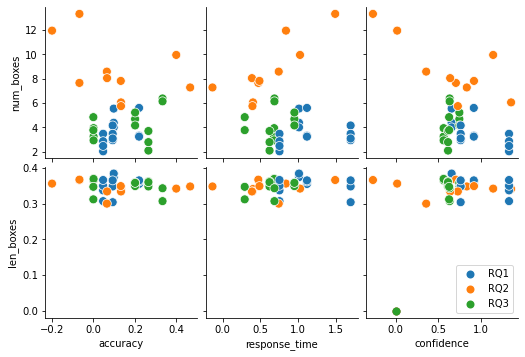

In [38]:
df_means_num, pp_data_num = get_data_response_interaction_pair_plot(means_h)
pair_plot_response_interaction(df_means_num, pp_data_num)

## Non-hierarchical Interaction

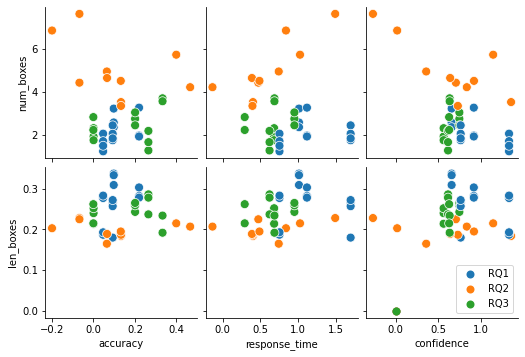

In [39]:
df_means_num, pp_data_num = get_data_response_interaction_pair_plot(means_nh)
pair_plot_response_interaction(df_means_num, pp_data_num)